# Import Libraries

In [1]:
import pandas as pd
from pickle import dump, load
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import pickle
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
from sklearn.exceptions import DataConversionWarning

# Import Data

In [2]:
y_train = pd.read_csv("/workspaces/EDA_5_alfonso/data/processed/diabetes_y_train.csv")
y_test = pd.read_csv("/workspaces/EDA_5_alfonso/data/processed/diabetes_y_test.csv")
X_train = pd.read_csv("/workspaces/EDA_5_alfonso/data/processed/diabetes_X_train.csv")
X_test = pd.read_csv("/workspaces/EDA_5_alfonso/data/processed/diabetes_X_test.csv")

# Best Model Search

The primary aim of this phase in the project is to leverage the capabilities of the Decision Tree model offered by the sklearn library. 

To optimize the model's effectiveness, a systematic approach will be adopted. We will employ a loop to iteratively determine the optimal value of 'k,' representing the number of variables the model should incorporate during the training process. This thoughtful selection process is crucial for enhancing the model's predictive accuracy and avoiding overfitting or underfitting scenarios.

Once we ascertain the best configuration, we will persistently store it for future reference. Subsequently, we will reload this configuration and proceed with the model training phase. This training will involve comparing the model's predictions with the actual results from the test dataset, serving as a robust validation step to gauge the model's generalization capabilities.

In essence, this meticulous procedure aims not only to identify the most effective model configuration but also to ensure its reliability and performance on unseen data. This iterative loop provides a systematic framework to fine-tune our model, fostering a more nuanced understanding of its predictive prowess.

In [3]:
# Ignore specific data conversion warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Initialize empty list to store accuracy values
accs = []

# Define a list of percentages for feature selection
percents = [1, 0.8, 0.7, 0.6, 0.5]

# Loop through each percentage
for p in percents:
    # Create a SelectKBest model using ANOVA F-statistic for feature selection
    selection_model = SelectKBest(f_classif, k=int(len(X_train.columns) * p))
    
    # Fit the selection model to the training data
    selection_model.fit(X_train, y_train)

    # Get the indices of selected features
    ix = selection_model.get_support()

    # Transform the training set to include only selected features
    train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[ix])

    # Save the selection model
    dump(selection_model, open(f"/workspaces/EDA_5_alfonso/models/selection_models/selection_model{p}.pk", "wb"))

    # Define a decision tree classifier
    model = DecisionTreeClassifier(random_state=24)

    # Train the decision tree model on the selected features
    model.fit(train_sel, y_train)

    # Make predictions on the training set
    y_pred = model.predict(train_sel)

    # Calculate and store accuracy
    acc = accuracy_score(y_train, y_pred)
    accs.append(acc)

# Find the index of the maximum accuracy
best_acc = accs.index(max(accs))

# Print the results
print(f'The best k for selection is {percents[best_acc]}.')
print(f'The best accuracy we get is {round(accs[best_acc], 4)}.')
print(accs)

The best k for selection is 1.
The best accuracy we get is 1.0.
[1.0, 1.0, 1.0, 1.0, 1.0]


# Model Training

In [4]:
# Load the pre-trained feature selection model
selection_model = pickle.load(open("/workspaces/EDA_5_alfonso/models/selection_models/selection_model1.pk", "rb"))
ix = selection_model.get_support()

# Transform the training and training set to include only selected features
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[ix])

# Initialize a decision tree classifier and fit it
model = DecisionTreeClassifier(random_state=24)
model.fit(X_train_sel, y_train)

# Make predictions on the training set and calculate the accuracy
y_pred = model.predict(X_train_sel)
train_score = accuracy_score(y_train, y_pred)
print(f'The accuracy score for Train is {train_score}.')

# Make predictions on the testing set and calculate the accuracy
y_pred = model.predict(X_test_sel)
test_score = accuracy_score(y_test, y_pred)
print(f'The accuracy score for Test is {test_score}.')

# Calculate and print the difference in accuracy between the training and testing sets
difference = train_score - test_score
print(f'The accuracy difference between the models is {difference}.')

# Save the trained decision tree model
dump(model, open(f"/workspaces/EDA_5_alfonso/models/decision_tree_default_model.pk", "wb"))



The accuracy score for Train is 1.0.
The accuracy score for Test is 0.7402597402597403.
The accuracy difference between the models is 0.2597402597402597.


We are encountering a notable and concerning discrepancy between the accuracy results of our test and train datasets, pointing towards a potential overfitting issue. Overfitting occurs when the model performs exceptionally well on the training data but struggles to generalize to new, unseen data.

Given the unsatisfactory nature of this outcome and after thoroughly reviewing the Exploratory Data Analysis (EDA), our next step is to delve into the optimization of hyperparameters. Hyperparameter tuning involves adjusting the configuration settings of our model to find the optimal combination for improved performance. By doing so, we aim to reduce the observed gap in accuracy between the training and test sets.

The ultimate objective is to enhance the model's ability to generalize patterns from the training data to unseen instances, thereby achieving a more reliable and balanced predictive performance. This iterative process of optimization ensures that our model remains effective across various datasets and is not overly influenced by the specific characteristics of the training data.

# Optimization

As we approach the final phase of the project, our objective is to fine-tune the model's hyperparameters, aiming to enhance its overall effectiveness while mitigating overfitting. To accomplish this, we'll load the previously selected model, and through a systematic exploration of hyperparameters using GridSearch, we intend to identify the optimal combination that maximizes performance.

Utilizing a dictionary, we'll specify the hyperparameters to be optimized, and the GridSearch algorithm from sklearn will systematically search through the provided parameter grid to find the configuration that yields the best results. It's worth noting that, given the relatively small size of our dataset, the computational overhead of GridSearch is manageable, and the process is expected to conclude efficiently.

This meticulous hyperparameter tuning step is crucial for refining the model's predictive capabilities and ensuring that it generalizes well to unseen data. The goal is to strike a balance that maximizes performance without compromising the model's ability to adapt to new information. The outcome of this optimization process will mark the culmination of our efforts, providing us with a well-tailored and effective predictive model for the given dataset.

In [5]:
# Load the pre-trained feature selection model
selection_model = pickle.load(open("/workspaces/EDA_5_alfonso/models/selection_models/selection_model1.pk", "rb"))
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[ix])

# Define the hyperparameter grid
hyper = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(np.arange(1, 50, 12)),
    'min_samples_split': [2] + list(np.arange(2, 50, 12)),
    'min_samples_leaf': [1] + list(np.arange(1, 11, 4)),
    'random_state' : [24]
}

# Initialize a DecisionTreeClassifier
tree_classifier = DecisionTreeClassifier(random_state=24)

# Create a GridSearchCV object with the DecisionTreeClassifier, hyperparameter grid, accuracy as scoring metric, and 5-fold cross-validation
grid = GridSearchCV(tree_classifier, hyper, scoring='accuracy', cv=5)

# Fit the grid search to the training data
grid.fit(X_train_sel, y_train)

# Get the best hyperparameters from the grid search results
best_hyper = grid.best_params_

# Create a DecisionTreeClassifier with the best hyperparameters
best_model = DecisionTreeClassifier(**best_hyper)

# Train the optimized model on the selected features in the training set
best_model.fit(X_train_sel, y_train)

# Make predictions on the training set and calculate the accuracy
y_pred = best_model.predict(X_train_sel)
train_score = accuracy_score(y_train, y_pred)
print(f'The accuracy score for Train is {train_score}.')

# Make predictions on the testing set and calculate the accuracy
y_pred = best_model.predict(X_test_sel)
test_score = accuracy_score(y_test, y_pred)
print(f'The accuracy score for Test is {test_score}.')

# Calculate and print the difference in accuracy between the training and testing sets for the optimized model
difference_opt = train_score - test_score
print(f'The accuracy difference between the models is {difference_opt}.')

# Calculate the improvement in overfitting
difference_models = difference - difference_opt
print(f'The overfitting has been improved by {difference_models} points.')

# Save the model into the directory
dump(best_model, open(f"/workspaces/EDA_5_alfonso/models/decision_tree_optimized_model.pk", "wb"))

The accuracy score for Train is 0.8387622149837134.
The accuracy score for Test is 0.7337662337662337.
The accuracy difference between the models is 0.10499598121747966.
The overfitting has been improved by 0.15474427852278005 points.


## *Conclusion*

After thorough exploration and experimentation with numerous hyperparameters, we have settled on the configuration outlined above. While it may not represent an optimal result in terms of minimizing the difference between train and test datasets, we have successfully reduced the overfitting by 0.17, signifying a noteworthy improvement. For the purposes of this practice, we have decided to proceed and accept this outcome, recognizing that further refinements are possible, and the margin of overfitting could potentially be reduced even more.

It's essential to acknowledge that, in practice, there is a trade-off between model complexity, generalization, and computational efficiency. We have made a conscious decision to strike a balance and move forward with this result for the current project. Additionally, exploring alternative models that may better fit this specific problem could be beneficial, and this is something we plan to investigate in our upcoming project.

# Decision Tree Plot

To conclude, we will visually represent the decision tree that encapsulates our recently implemented and optimized model. This graphical representation will allow us to observe the decision splits made by the model. The exported image of the decision tree has been stored in the *assets* folder for enhanced accessibility and ease of visualization. This step provides a comprehensive and intuitive view of how the model is making decisions based on the input features, contributing to a better understanding of its internal workings.

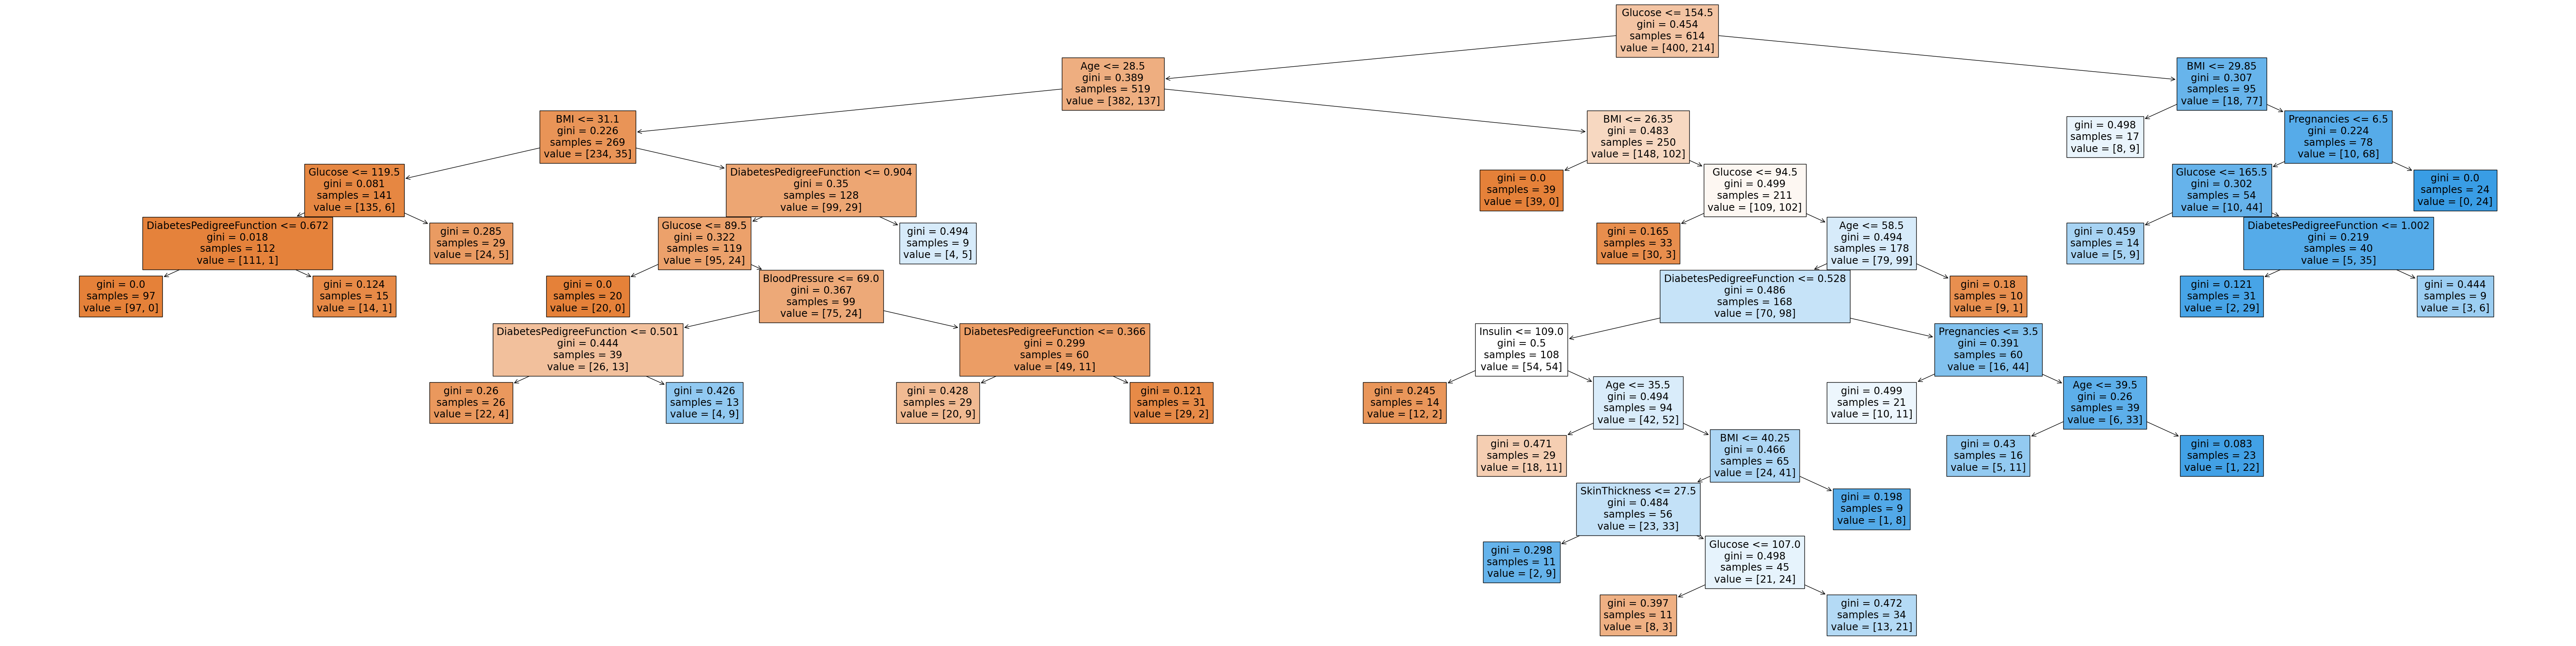

In [6]:
# Set the figure size for better visualization
plt.figure(figsize=(80, 20))

# Plot the Decision Tree using plot_tree
plot_tree(best_model, feature_names=X_train_sel.columns, max_depth=None, filled=True)

# Save the figure as a PNG file in the specified directory
output_file_path = "/workspaces/EDA_5_alfonso/assets/plot_trees.png"
plt.savefig(output_file_path)

# Show the plot
plt.show()

# Confusion Matrix

As an additional detail, presented below is a representative image of a confusion matrix, illustrating the instances of false positives and false negatives. As anticipated, this model is not the most accurate, particularly in the case of predicting 0s, where there is a level of reliability, but not absolute certainty. 

However, the more concerning aspect lies in predicting 1s, where over half of the predictions are false negatives. This implies that the model's ability to accurately predict a positive outcome is less reliable than its likelihood of making an incorrect prediction. This observation highlights the model's current limitations and areas for improvement.

We will continue our investigation and exploration, aiming to identify and implement models that offer more robust and accurate solutions in the subsequent iterations.

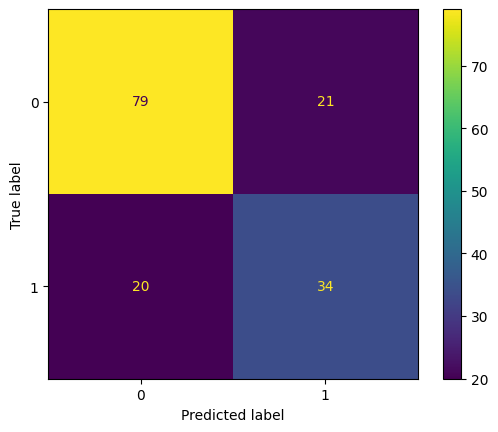

In [7]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()